In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 100行"深度学习"框架

Credit：[karpathy/micrograd](https://github.com/karpathy/micrograd)

In [2]:
def unbroadcast(out, shape):
    sum_axis = [i for i in range(len(shape)) if shape[i]==1 and out.shape[i] > 1]
    return out.sum(axis=tuple(sum_axis)).reshape(shape)

class Tensor(object):
    def __init__(self, data, children=(), op="", grad_required=True, name=""):
        self.data = data
        self.grad_required = grad_required
        self.grad = np.zeros_like(data) if grad_required else None
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(children)
        self._op = op
        self._name = name

    def zero_grad(self):
        if self.grad_required:
            self.grad = np.zeros_like(self.data)

    def backward(self):
        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = np.ones_like(self.data)
        for v in reversed(topo):
            v._backward()

    # operators
    def mean(self):
        out = Tensor(self.data.mean(), (self, ), 'mean')

        def _backward():
            if self.grad_required:
                self.grad += out.grad * np.ones_like(self.grad) / self.grad.data.shape[0]
        out._backward = _backward

        return out

    def matmul(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other, grad_required=False)
        out = Tensor(self.data @ other.data, (self, other), 'matmul')

        def _backward():
            if self.grad_required:
                self.grad += out.grad @ other.data.T
            if other.grad_required:
                other.grad += self.data.T @ out.grad
        out._backward = _backward

        return out

    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other, grad_required=False)
        out = Tensor(self.data + other.data, (self, other), '+')

        def _backward():
            if self.grad_required:
                self.grad += unbroadcast(out.grad, self.grad.shape)
            if other.grad_required:
                other.grad += unbroadcast(out.grad, other.grad.shape)
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other, grad_required=False)
        out = Tensor(self.data * other.data, (self, other), '*')

        def _backward():
            if self.grad_required:
                self.grad += unbroadcast(other.data * out.grad, self.grad.shape)
            if other.grad_required:
                other.grad += unbroadcast(self.data * out.grad, other.grad.shape)
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Tensor(self.data**other, (self,), f'**{other}')

        def _backward():
            if self.grad_required:
                self.grad += unbroadcast((other * self.data**(other-1)) * out.grad, self.grad.shape)
        out._backward = _backward

        return out

    def relu(self):
        out = Tensor(np.maximum(self.data, 0), (self,), 'relu')

        def _backward():
            if self.grad_required:
                self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Tensor(data={self.data}, grad={self.grad}, shape={self.data.shape})"

# 框架应用

/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


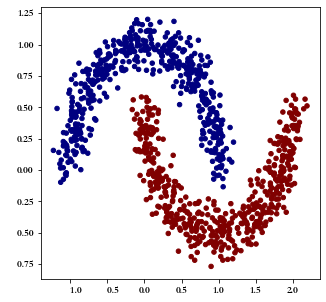

In [3]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [4]:
class Model(object):
    def __init__(self):
        self.w1 = Tensor(np.random.uniform(-1,1,(2,16)), name="w1")
        self.b1 = Tensor(np.random.uniform(-1,1,(1,16)), name="b1")
        self.w2 = Tensor(np.random.uniform(-1,1,(16,16)), name="w2")
        self.b2 = Tensor(np.random.uniform(-1,1,(1,16)), name="b2")
        self.w3 = Tensor(np.random.uniform(-1,1,(16,1)), name="w3")
        self.b3 = Tensor(np.random.uniform(-1,1,(1,1)), name="b3")
        self.params = [self.w1, self.b1, self.w2, self.b2, self.w3, self.b3]
    def forward(self, x):
        t = Tensor(x.reshape(-1,2), grad_required=False)
        h1 = t.matmul(self.w1) + self.b1
        h1 = h1.relu()
        h2 = h1.matmul(self.w2) + self.b2
        h2 = h2.relu()
        out = h2.matmul(self.w3) + self.b3
        return out
    def zero_grad(self):
        for param in self.params:
            param.zero_grad()
            
def train(model, X, y, epochs, learning_rate):
    for i in range(epochs):
        p = m.forward(X)
        loss = (1-p*y.reshape(-1,1)).relu()
        loss = loss.mean()
        m.zero_grad()
        loss.backward()
        for param in m.params:
            param.data -= param.grad*learning_rate
        print(f"epoch = {i}, loss = {loss.data}")

In [5]:
m = Model()
train(m, X, y, epochs=100, learning_rate=0.5)

epoch = 0, loss = 1.9251081172714235
epoch = 1, loss = 1.4476306400274388
epoch = 2, loss = 0.9911278803605992
epoch = 3, loss = 0.5661733836369287
epoch = 4, loss = 0.3732116005850639
epoch = 5, loss = 0.30307752090242435
epoch = 6, loss = 0.2641709534728665
epoch = 7, loss = 0.24000768402243178
epoch = 8, loss = 0.21148220200373657
epoch = 9, loss = 0.24439686452195117
epoch = 10, loss = 0.29879296111547354
epoch = 11, loss = 0.25631624384818996
epoch = 12, loss = 0.16920879908617079
epoch = 13, loss = 0.14858723259575607
epoch = 14, loss = 0.14103842756548393
epoch = 15, loss = 0.13960799717359293
epoch = 16, loss = 0.15174937226385368
epoch = 17, loss = 0.142032423426493
epoch = 18, loss = 0.17606285162719865
epoch = 19, loss = 0.12423657387414719
epoch = 20, loss = 0.10863318354622141
epoch = 21, loss = 0.09330235175200402
epoch = 22, loss = 0.10026045804418478
epoch = 23, loss = 0.09027857863451923
epoch = 24, loss = 0.12670918956684685
epoch = 25, loss = 0.10483002367667416
epoc

epoch = 73, loss = 0.008312196898058127
epoch = 74, loss = 0.008154656823477362
epoch = 75, loss = 0.008013133483851463
epoch = 76, loss = 0.00790211603476695
epoch = 77, loss = 0.0077974569193258415
epoch = 78, loss = 0.007636345078429355
epoch = 79, loss = 0.007493777523836703
epoch = 80, loss = 0.007405471168049397
epoch = 81, loss = 0.00725290059216436
epoch = 82, loss = 0.00711773914065917
epoch = 83, loss = 0.00705057964838418
epoch = 84, loss = 0.0068469946140174405
epoch = 85, loss = 0.0067114020848411836
epoch = 86, loss = 0.006606743244938297
epoch = 87, loss = 0.006499044269306717
epoch = 88, loss = 0.006402468002412698
epoch = 89, loss = 0.006295786774390771
epoch = 90, loss = 0.006210487165188564
epoch = 91, loss = 0.0060676804598913565
epoch = 92, loss = 0.005932733433439804
epoch = 93, loss = 0.005813498806521835
epoch = 94, loss = 0.0057049504262648345
epoch = 95, loss = 0.00560573449597206
epoch = 96, loss = 0.005596965716673067
epoch = 97, loss = 0.005531481813237726


(-1.769073483078647, 1.980926516921353)

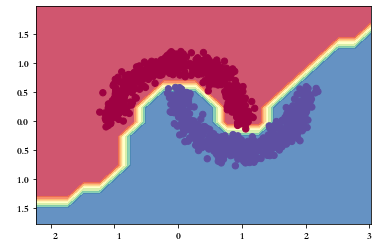

In [6]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
scores = [m.forward(i) for i in Xmesh]
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# 神经网路图分析

In [7]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        label = f"Tensor({n._name},shape={n.data.shape})" if n._name else f"Tensor(shape={n.data.shape})"
        dot.node(name=str(id(n)), label=label, shape="record")
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [8]:
z = m.forward(X[0])

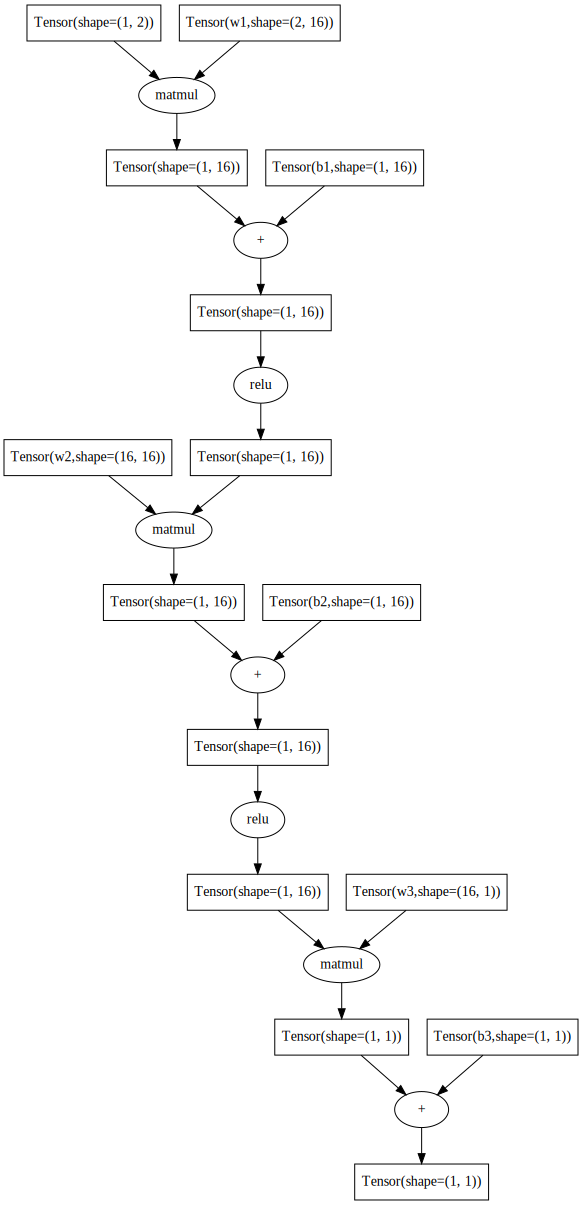

In [9]:
draw_dot(z, rankdir="TB")

In [10]:
z

Tensor(data=[[2.25810903]], grad=[[0.]], shape=(1, 1))

In [11]:
z.backward()

In [12]:
z

Tensor(data=[[2.25810903]], grad=[[1.]], shape=(1, 1))